In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

IMG_WIDTH, IMG_HEIGHT = 224, 224

import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import (
    DenseNet121,
    preprocess_input,
)
import pandas as pd
import numpy as np
import os
import IPython.display as display
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Conv2D,
    Flatten,
    GlobalMaxPooling2D,
    Dropout,
    Activation
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from datetime import datetime
from packaging import version
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import efficientnet.tfkeras as enet



def append_extension(fn):
    return (fn + ".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[: class_number - 2] = 1
    return target


DATADIR = r"./adult"
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(CSV_PATH, sheet_name=0,)[["GreenID", "Grade"]].dropna(
    axis=0, subset=["Grade"]
)
response.Grade = response.Grade.astype("int")
response.GreenID = response.GreenID.astype("str").apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat(
    [response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T,],
    axis=1,
)


# shuffle dataset
response = response.sample(frac=1)
seed = np.random.randint(30027)

@tf.function
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

@tf.function
def soft_acc_multi_output(y_true, y_pred):
    return K.mean(
        K.all(
            K.equal(
                K.cast(K.round(y_true), "int32"), K.cast(K.round(y_pred), "int32"),
            ),
            axis=1,
        )
    )

# policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
# mixed_precision.experimental.set_policy(policy)

# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices("GPU")
# #         print(
# #             len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs",
# #         )
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [ ]:
# data_gen = ImageDataGenerator(
#     rotation_range=5,
#     fill_mode='reflect',
#     horizontal_flip=True,
# #     vertical_flip=True,
#     validation_split=0.1,
#     rescale=1. / 255.,
# #     preprocessing_function = preprocess_input
#     zoom_range = 0.1
# )

# train_set = data_gen.flow_from_dataframe(
#     dataframe=response,
#     directory=DATADIR,
#     x_col="GreenID",
#     y_col="Grade",
#     target_size=(224,224),
#     color_mode='rgb',
#     class_mode='raw',
#     subset = "training",
#     shuffle=True,
# #     class_mode = "sparse"
# )

# validation_set = data_gen.flow_from_dataframe(
#     dataframe=response,
#     directory=DATADIR,
#     x_col="GreenID",
#     y_col="Grade",
#     target_size=(224,224),
#     color_mode='rgb',
#     batch_size = 28,
#     class_mode='raw',
#     subset = "validation",
#     shuffle=True,
# #     class_mode = "sparse"
# )

In [3]:
# base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))
# base_model.trainable = False

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.8)(x)
# preds = Dense(1, activation="linear", bias_initializer = tf.keras.initializers.Constant(value=4),
# #               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#              bias_constraint = tf.keras.constraints.MinMaxNorm(min_value=2, max_value=6, rate=1.0, axis=0),
#              )(x)
# model = Model(inputs=base_model.input, outputs=preds, name = "densenet_fine_tune_70_")

# model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=[soft_acc])


# # hinge loss doesnt work, for some reason(?) hinge loss is for multi-class output; loss for a "single" output will always be 0
# # first train with feature extractor freezed

# early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
# reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

# history = model.fit_generator(generator=train_set,
#                     epochs=50,
#                     verbose=1,
#                     validation_data=validation_set,
# #                     validation_freq=2,
#                     callbacks = [early_stopping, reduce_lr_plateau]
#                     )

# # model.save(filepath ="./saved_models/my_densenet_regression/1/untuned.h5")
# model = tf.keras.models.load_model(filepath ="./saved_models/my_densenet_regression/1/untuned.h5",custom_objects={'soft_acc':soft_acc})

In [6]:
# for layer in model.layers[70:]:
#     layer.trainable = True

# model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=[soft_acc])
# len(model.trainable_variables)

# logdir_name = r".\tfb\logs\densenet_regression\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
# early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
# reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)
# history_fine = model.fit_generator(generator=train_set,
#                     epochs=100,
#                     validation_data=validation_set,
#                     callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau ]
#                     )

# model.save(filepath ="./saved_models/my_densenet_regression/1/best_weight.h5")

Epoch 1/100
16/16 [==============================] - 15s 952ms/step - loss: 3.7844 - soft_acc: 0.2038 - val_loss: 7.4277 - val_soft_acc: 0.1786
Epoch 2/100
16/16 [==============================] - 12s 730ms/step - loss: 2.6934 - soft_acc: 0.2721 - val_loss: 7.2248 - val_soft_acc: 0.0714
Epoch 3/100
16/16 [==============================] - 11s 713ms/step - loss: 2.1013 - soft_acc: 0.3014 - val_loss: 3.2595 - val_soft_acc: 0.1964
Epoch 4/100
16/16 [==============================] - 11s 705ms/step - loss: 1.7496 - soft_acc: 0.3170 - val_loss: 9.4977 - val_soft_acc: 0.0179
Epoch 5/100
16/16 [==============================] - 12s 724ms/step - loss: 2.1163 - soft_acc: 0.3625 - val_loss: 2.6740 - val_soft_acc: 0.0893
Epoch 6/100
16/16 [==============================] - 11s 710ms/step - loss: 2.4370 - soft_acc: 0.2939 - val_loss: 6.0897 - val_soft_acc: 0.0000e+00
Epoch 7/100
16/16 [==============================] - 12s 732ms/step - loss: 1.2040 - soft_acc: 0.3275 - val_loss: 9.4389 - val_soft_

In [2]:
# @tf.function
def generate_base_model():
    base_model = DenseNet121(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, bias_initializer=tf.keras.initializers.Constant(value=4),
        bias_constraint=tf.keras.constraints.MinMaxNorm(
            min_value=2, max_value=6, rate=1.0, axis=0
        ))(x)
    preds = Activation(
        "linear",
        dtype="float32",
        
    )(x)
    model = Model(inputs=base_model.input, outputs=preds)

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0014), loss="mse", metrics=[soft_acc]
    )

    return model


trainable_sequence = np.array([429, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412,
       411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399,
       398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
       372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
       359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
       346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
       333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321,
       320, 319, 318, 317, 316, 315, 314, 313, 311, 308, 307, 306, 305,
       304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292,
       291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279,
       278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266,
       265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253,
       252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240,
       239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227,
       226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214,
       213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201,
       200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
       187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175,
       174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162,
       161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149,
       148, 147, 146, 145, 144, 143, 142, 141, 139, 136, 135, 134, 133,
       132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120,
       119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  51,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   4,   3,   2])

# @tf.function
def fine_tune_model(model, fine_tune=None):
    if fine_tune is None:
        try:
            fine_tune = 424
        except:
            pass

    model.trainable = True
    for layer in model.layers[:fine_tune]:
        layer.trainable = False
    for layer in model.layers[fine_tune:]:
        layer.trainable = True

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0003),
        loss="mse",
        metrics=[soft_acc],
    )

    return model

# @tf.function
def generate_train_val_test(train_index, val_index, test_index):
    train_dataset = response.iloc[train_index]
    val_dataset = response.iloc[val_index]
    test_dataset = response.iloc[test_index]
    train_gen = ImageDataGenerator(
        rotation_range=5,
        fill_mode="reflect",
        horizontal_flip=True,
        rescale=1.0 / 255.0,
        zoom_range=0.1,
    )
    valid_test_gen = ImageDataGenerator(rescale=1.0 / 255.0,)

    train_set = train_gen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=True,
        y_col="Grade",
        class_mode="raw",
    )

    validation_set = train_gen.flow_from_dataframe(
        dataframe=val_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col="Grade",
        class_mode="raw",
    )

    test_set = valid_test_gen.flow_from_dataframe(
        dataframe=test_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col="Grade",
        class_mode="raw",
    )
    return train_set, validation_set, test_set


from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
innerkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
response = response.sample(frac=1.0)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

NameError: name 'seed' is not defined

In [3]:
# @tf.function
def stratified_cv(fine_tune_layer=None):
    acc_coef_scores = []
    raw_outputs = []
    for train_index, val_test_index in kf.split(
        np.zeros(len(response)), response["Grade"]
    ):
        val_index, test_index = next(
            innerkf.split(
                np.zeros(len(val_test_index)), response["Grade"].iloc[val_test_index]
            )
        )
        val_index, test_index = val_test_index[val_index], val_test_index[test_index]
        train_set, validation_set, test_set = generate_train_val_test(
            train_index, val_index, test_index
        )
        model = generate_base_model()

#         _ = model.fit(
#             x=train_set,
#             epochs=15,
#             validation_data=validation_set,
#             callbacks=[early_stopping, reduce_lr_plateau],
#             #         verbose=0,
#         )

        model = fine_tune_model(model, fine_tune=fine_tune_layer)

        _ = model.fit(
            x=train_set,
            epochs=200,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
                    verbose=0,
        )

        batch = next(test_set)
        true_labels = batch[1]
        predictions = model.predict(batch[0])
        acc = soft_acc_multi_output(predictions, true_labels).numpy()
        corr = np.corrcoef(predictions.reshape(-1), true_labels)[0][1]
        acc_coef_scores.append([acc, corr])
        raw_outputs.append([np.array(response.iloc[test_index].index), true_labels, predictions.reshape(-1)])
        del train_set, validation_set, test_set, _, model, batch, true_labels, predictions, acc, corr
        tf.keras.backend.clear_session()
        gc.collect()
    return acc_coef_scores, raw_outputs

In [ ]:
from tqdm import tqdm

import gc

fine_tune_scores_acc_coef = []
fine_tune_raw_outputs = []

for i in tqdm(range(360,0,-12)):
    
    fine_tune = trainable_sequence[i]
    acc_coef_scores, raw_outputs = stratified_cv(fine_tune)
    fine_tune_scores_acc_coef.append(acc_coef_scores)
    fine_tune_raw_outputs.append(raw_outputs)
    np.save(r"./stratified_cross_validation_results/densenets/regression_acc_coef", np.array(fine_tune_scores_acc_coef))
    np.save(r"./stratified_cross_validation_results/densenets/regression_raw_outputs", np.array(fine_tune_raw_outputs))
    del acc_coef_scores, raw_outputs
    tf.keras.backend.clear_session()
    gc.collect()

30
[[28 14  1  1  0]
 [10 24 19  1  0]
 [10 21 36 10  2]
 [ 0  0 17 28  4]
 [ 0  0 17 31  8]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
[[0.63636364 0.31818182 0.02272727 0.02272727 0.        ]
 [0.18518519 0.44444444 0.35185185 0.01851852 0.        ]
 [0.12658228 0.26582278 0.4556962  0.12658228 0.02531646]
 [0.         0.         0.34693878 0.57142857 0.08163265]
 [0.         0.         0.30357143 0.55357143 0.14285714]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
Accuracy:  43.97163120567376
Raw Correlation:  0.7506412608853257
Rounded Correlation:  0.7336775216640599
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
max accuracy with tuning from 71 layers, or tune 359 layers
1 [63.63636363636363, 44.44444444444444, 45.56962025316456, 57.14285714285714, 14.285714285714285]


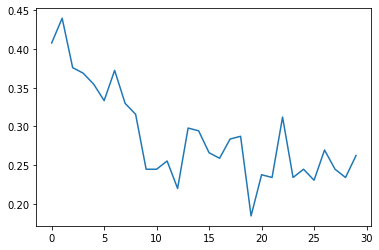

In [1]:
import numpy as np

acc_coef = np.load(
    r"./stratified_cross_validation_results/densenets/regression_acc_coef.npy",
    allow_pickle=True,
)
raw_outputs = np.load(
    r"./stratified_cross_validation_results/densenets/regression_raw_outputs.npy",
    allow_pickle=True,
)
print(len(acc_coef))


from sklearn.metrics import confusion_matrix



def show_confusion_matrix(raw_outputs, fine_tune_layers):

    y_true = np.hstack(raw_outputs[fine_tune_layers, :, 1])
    y_pred = np.rint(np.hstack(raw_outputs[fine_tune_layers, :, 2])).astype("int")
    y_pred[y_pred > 6] = 6
    y_pred[y_pred < 2] = 2
    return confusion_matrix(y_true, y_pred)


def show_matrix_percentage(confusion_matrix):
    return np.transpose(
        np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1)
    )


# total accuracy
def calculate_accuracy(my_confusion_matrix):
    return np.trace(my_confusion_matrix) / np.sum(my_confusion_matrix)


def raw_correlation(raw_outputs, fine_tune_layers):
    y_true = np.hstack(raw_outputs[fine_tune_layers, :, 1]).astype(float)
    y_pred = np.hstack(raw_outputs[fine_tune_layers, :, 2]).astype(float)
    y_pred[y_pred > 6] = 6.0
    y_pred[y_pred < 2] = 2.0
    return np.corrcoef(y_true, y_pred)


def rounded_correlation(raw_outputs, fine_tune_layers):
    y_true = np.hstack(raw_outputs[fine_tune_layers, :, 1]).astype(float)
    y_pred = np.rint(np.hstack(raw_outputs[fine_tune_layers, :, 2])).astype("int")
    y_pred[y_pred > 6] = 6.0
    y_pred[y_pred < 2] = 2.0
    return np.corrcoef(y_true, y_pred)


max_acc_layer = np.argmax([calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])

my_confusion_matrix = show_confusion_matrix(raw_outputs, max_acc_layer)
print(my_confusion_matrix)
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(show_matrix_percentage(my_confusion_matrix))
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print("Accuracy: ",calculate_accuracy(my_confusion_matrix)*100)
print("Raw Correlation: ",raw_correlation(raw_outputs,max_acc_layer)[0][1])
print("Rounded Correlation: ",rounded_correlation(raw_outputs,max_acc_layer)[0][1])
import matplotlib.pyplot as plt



plt.plot(
    [i for i in range(len(acc_coef))],
    [
        calculate_accuracy(show_confusion_matrix(raw_outputs, i))
        for i in range(len(acc_coef))
    ],
)

trainable_sequence = np.array([429, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412,
       411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399,
       398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
       372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
       359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
       346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
       333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321,
       320, 319, 318, 317, 316, 315, 314, 313, 311, 308, 307, 306, 305,
       304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292,
       291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279,
       278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266,
       265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253,
       252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240,
       239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227,
       226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214,
       213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201,
       200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
       187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175,
       174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162,
       161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149,
       148, 147, 146, 145, 144, 143, 142, 141, 139, 136, 135, 134, 133,
       132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120,
       119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  51,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   4,   3,   2])

print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(f"max accuracy with tuning from {trainable_sequence[360:0:-12][max_acc_layer]} layers, or tune {430 - trainable_sequence[360:0:-12][max_acc_layer]} layers")
print(max_acc_layer, [show_matrix_percentage(my_confusion_matrix)[i,i]*100 for i in range(5)])

In [4]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
model = tf.keras.models.load_model(filepath ="./saved_models/my_densenet_regression/1/best_weight.h5",custom_objects={'soft_acc':soft_acc}, compile=False)
model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=[soft_acc])

In [5]:
test_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    batch_size = 56,
    class_mode='raw',
    subset = "validation",
    shuffle=True,
#     class_mode = "sparse"
)
model.evaluate(test_set)

Found 56 validated image filenames.
1/1 [==============================] - 4s 4s/step - loss: 0.7889 - soft_acc: 0.4107


[0.7889323830604553, 0.4107143]

In [6]:
batch = next(test_set)
true_labels = batch[1] 
predictions = model.predict(batch[0]).reshape(-1)
np.corrcoef(predictions, true_labels)

array([[1.        , 0.86952104],
       [0.86952104, 1.        ]])

In [7]:
predictions

array([4.8174267, 2.9545946, 2.0121977, 3.0494313, 1.9905353, 3.1861634,
       2.4777877, 2.5162086, 3.8922534, 4.6012893, 5.3105097, 3.0070274,
       3.582683 , 3.9239652, 2.5086799, 2.758663 , 4.6620855, 4.9011326,
       3.9428258, 3.3892407, 2.3458185, 5.003082 , 3.4692292, 1.5527499,
       2.812867 , 1.6151032, 4.2303686, 4.1937532, 3.2692575, 3.1533186,
       1.7551136, 4.180257 , 4.439666 , 2.1827962, 3.5347495, 2.5323863,
       4.551199 , 3.8940938, 3.1281133, 3.0512335, 2.9170604, 4.5494165,
       4.5460916, 4.0294747, 1.9733646, 2.5636935, 3.9428868, 1.8045533,
       2.296205 , 5.2323747, 4.665781 , 3.4958627, 2.1032124, 2.3734539,
       4.5092764, 4.90207  ], dtype=float32)

In [16]:
true_labels

array([6, 4, 2, 3, 2, 4, 3, 4, 3, 5, 6, 4, 3, 4, 3, 4, 6, 6, 4, 5, 3, 5,
       3, 2, 3, 2, 4, 5, 4, 3, 3, 6, 6, 2, 5, 4, 4, 4, 4, 4, 4, 6, 6, 4,
       2, 3, 5, 2, 2, 6, 6, 5, 3, 3, 5, 6])

In [25]:
plotdf = pd.DataFrame.from_dict({'True Label':true_labels, 'Predictions':predictions})
plotdf.Predictions = plotdf.Predictions.astype('category')

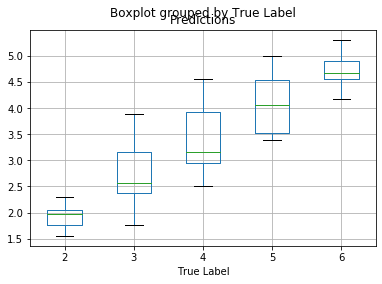

In [27]:
plotdf.boxplot(column = 'Predictions',by='True Label')

Text(0.5, 0, 'Predicted Value')

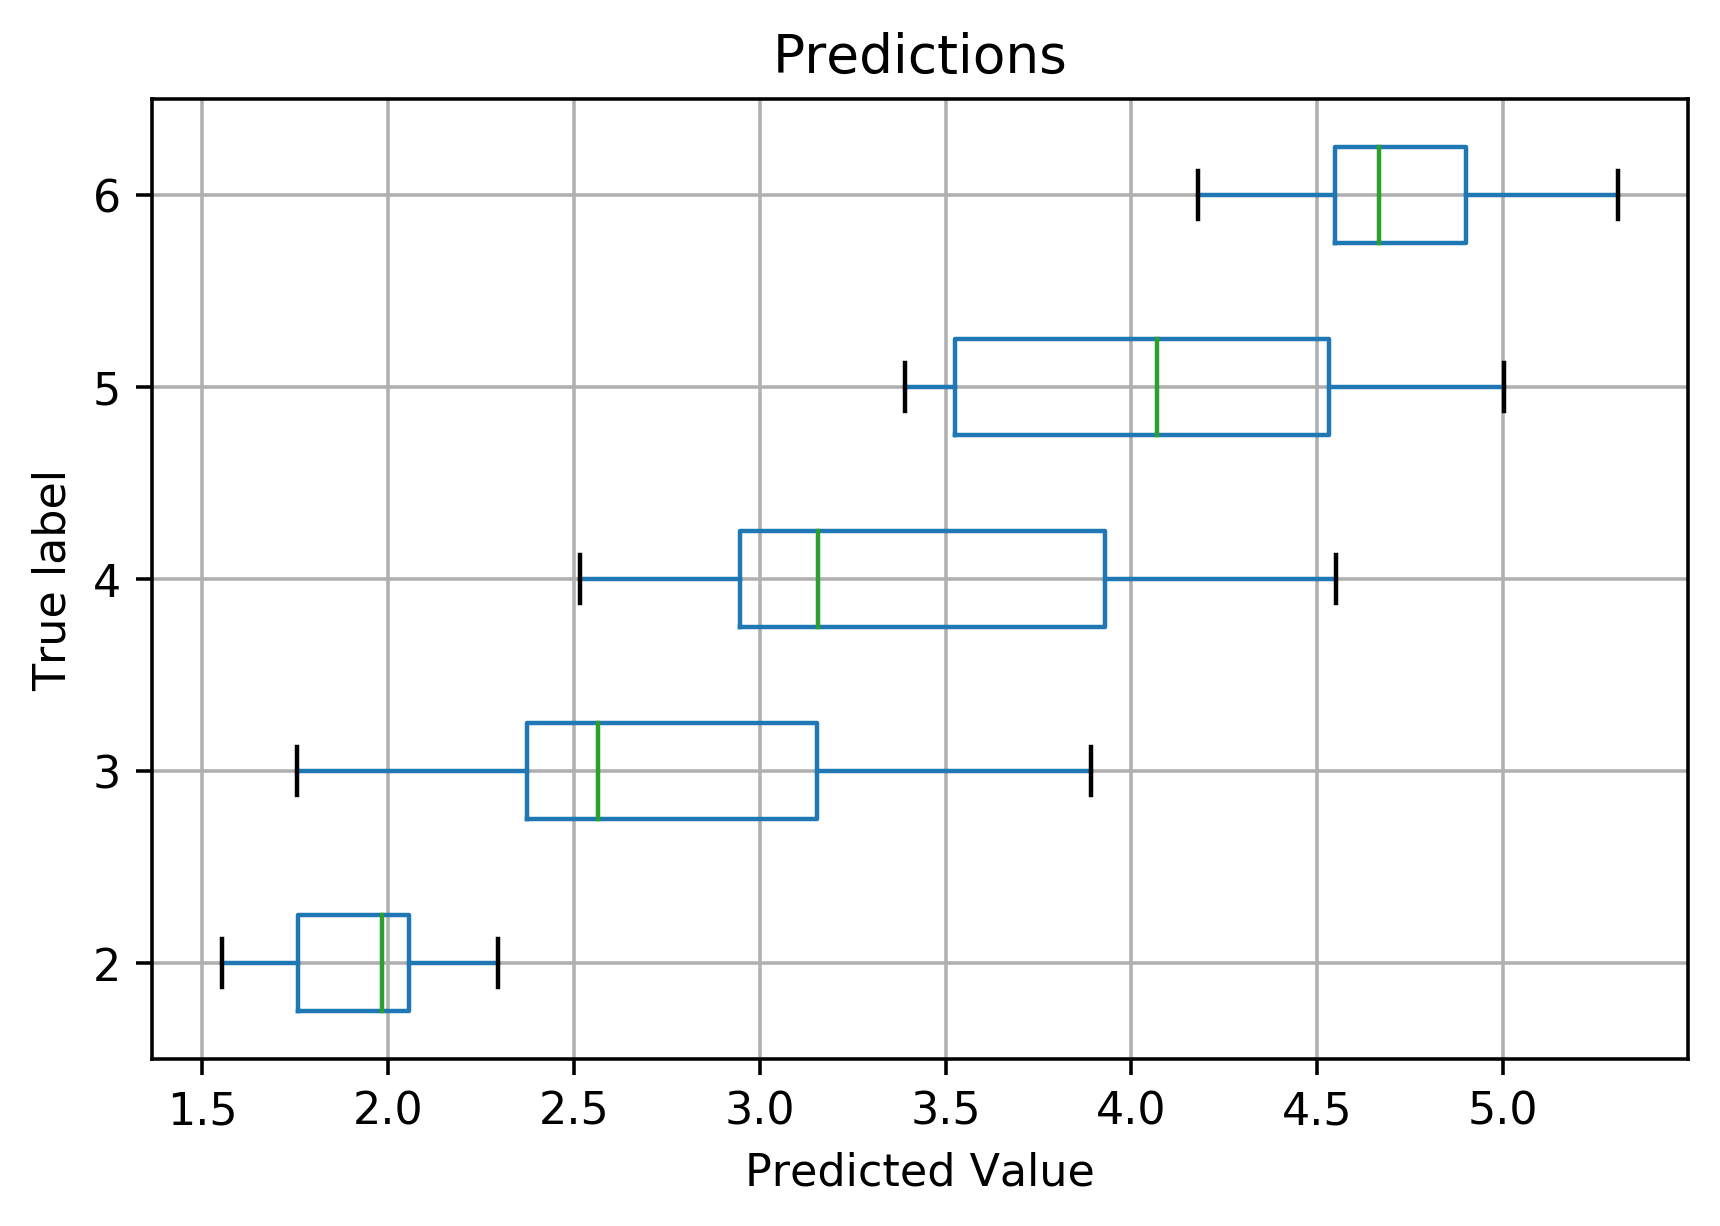

In [36]:
fig, ax = plt.subplots(dpi=320)
plotdf.boxplot(column = 'Predictions',by='True Label', ax=ax,  vert=False)
fig.suptitle('')
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Value")

In [37]:
fig.savefig('boxplot.png')

In [79]:
%load_ext tensorboard
%tensorboard --logdir C:\Users\feroc\OneDrive - The University of Melbourne\Dataset\tfb\logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-02-13 00:49:54.267359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_

Found 20 validated image filenames.


InvalidArgumentError: cannot compute Equal as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Equal]

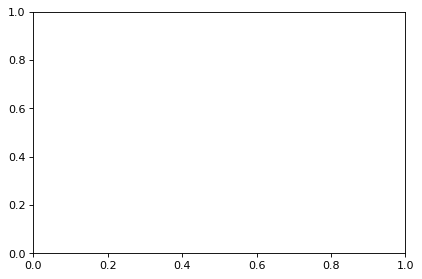

In [9]:
data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    rescale=1.0 / 255.0,
    zoom_range=0.1,
)


validation_set = data_gen.flow_from_dataframe(
    dataframe=response[:20],
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    batch_size = 28,
    class_mode='raw',
    subset = "training",
    shuffle=True,
#     class_mode = "sparse"
)


fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {model.predict(img.reshape(-1,224, 224, 3))}")

In [11]:
y_pred

array([[3.2390153],
       [3.0811794],
       [2.697922 ],
       [2.8569453],
       [2.5897331],
       [3.164951 ],
       [2.6220903],
       [2.6035929],
       [3.474424 ],
       [2.9674406],
       [2.7657166],
       [2.6560912],
       [2.841415 ],
       [2.780675 ],
       [2.8443027],
       [2.4560614],
       [2.4147856],
       [3.0213516],
       [2.4486613],
       [2.543878 ]], dtype=float32)